In [1]:
using CausalForest
using StatsBase
using Plots
using Random
using Distributions
using RCall
using BenchmarkTools
using DelimitedFiles

In [3]:
Random.seed!(123);
n, m = 10^4, 10;
u = Uniform(0,10);
features = rand(u, (n, m));
X = features;
d = Normal();
eps = rand(d, n);
b = Bernoulli();
T = convert(Vector{Int64},rand(b, n));
Y = 125*sin.(features*[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).*T  + features*[0, 0, 2, 0, 0, 0, 3, 0, 0, 0];

In [4]:
df = hcat(X,T,Y)

10000×12 Matrix{Float64}:
 9.063     0.273863  9.2398     5.83606   …  8.61508   1.0    76.6205
 4.43494   8.65398   4.38668    8.66793      5.79587   0.0    10.2415
 7.45673   7.98071   9.35901    5.96536      9.99516   0.0    27.5137
 5.12083   8.25448   8.79223    2.87236      8.06585   0.0    24.796
 2.53849   5.30423   5.84012    9.7704       9.6668    0.0    22.6625
 3.34152   2.66141   9.8669     9.76664   …  9.49805   1.0     0.498469
 4.27328   8.75436   0.0258112  0.863643     2.24987   1.0  -104.14
 8.67547   7.27313   0.151025   4.99536      0.765286  0.0    25.0373
 0.991336  1.20752   5.87184    3.17045      9.81301   0.0    20.8175
 1.25287   6.88003   3.64868    5.80333      3.00126   0.0    26.2578
 6.92209   0.298644  4.84843    8.11503   …  1.49476   0.0    36.4211
 1.36551   1.07227   0.570038   1.05282      7.60498   1.0   143.365
 0.320967  6.45858   4.85281    2.0843       1.98433   0.0    32.6943
 ⋮                                        ⋱            ⋮    
 1.41

In [5]:
#header = ["X1" "X2" "X3" "X4" "X5" "X6" "X7" "X8" "X9" "X10" "T" "Y"]
#writedlm("sinus_causal_5.csv", [header ; df], ",")

In [6]:
reval("set.seed(1)")
Xtest_1 = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
true_effect_1 = 125*sin.(Xtest_1[:, 1]);

In [7]:
function get_all_nodes_in_tree!(
    tree ,
    depth = 3,
    result  = []
    )
    if hasproperty(tree, :featid) && depth > 0
        push!(result, tree.featid)
        get_all_nodes_in_tree!(tree.left, depth-1, result)
        get_all_nodes_in_tree!(tree.right, depth-1, result)
    end
    return result
end

function get_freq(forest, depth=3) 
    ensemble = forest.trees
    n_trees = length(ensemble)
    res = []
    for i = 1:n_trees
        append!(res, get_all_nodes_in_tree!(forest.trees[i].tree, depth))
    end
    return proportionmap(res)
end

get_freq (generic function with 2 methods)

# Critère nouveau

### Subsampling

In [8]:
errors_11 = zeros(100)

cf = build_forest(false, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = 125*sin.(Xtest[:, 1])
    errors_11[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_11))
println(var(errors_11))

0.500997381972276
0.00038955029209489396


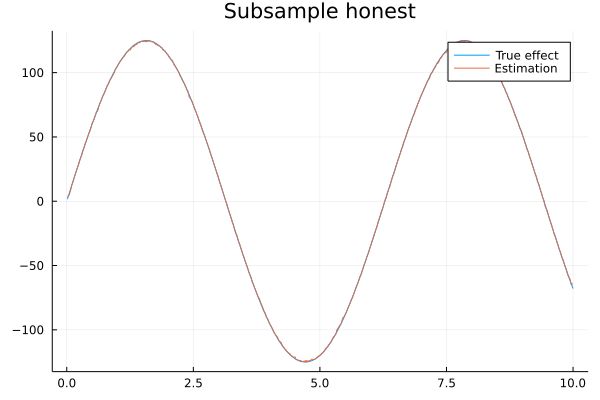

In [9]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Subsample honest", fmt = :png)

In [10]:
get_freq(cf, 3)

Dict{Any, Float64} with 1 entry:
  1 => 1.0

In [11]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 6.47543e-5
  4  => 0.000129509
  6  => 0.000194263
  7  => 6.47543e-5
  2  => 0.000323771
  10 => 6.47543e-5
  9  => 0.000129509
  8  => 0.000129509
  3  => 6.47543e-5
  1  => 0.998834

In [12]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0063548
  4  => 0.00544359
  6  => 0.00604712
  7  => 0.00591695
  2  => 0.00572761
  10 => 0.00541993
  9  => 0.00552643
  8  => 0.00637847
  3  => 0.00599979
  1  => 0.947185

### Bootstrap

In [13]:
errors_12 = zeros(100)

cf = build_forest(true, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_12[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = 125*sin.(Xtest[:, 1])
    errors_12[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_12))
println(var(errors_12))

1.231525294226372
0.0009325564926450533


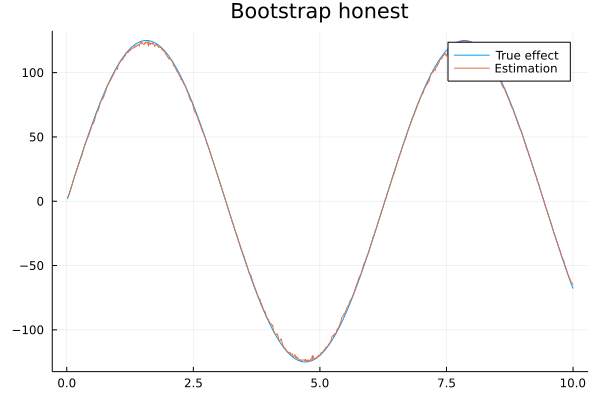

In [14]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Bootstrap honest", fmt = :png)

In [15]:
get_freq(cf, 3)

Dict{Any, Float64} with 1 entry:
  1 => 1.0

In [16]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 0.000323897
  4  => 0.000259118
  6  => 0.000388677
  7  => 0.000323897
  2  => 0.000129559
  10 => 0.000323897
  9  => 0.000453456
  8  => 0.000453456
  3  => 6.47794e-5
  1  => 0.997279

In [17]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0141475
  4  => 0.0132904
  6  => 0.01427
  7  => 0.0133846
  2  => 0.0134034
  10 => 0.0139403
  9  => 0.0123485
  8  => 0.0147127
  3  => 0.013394
  1  => 0.877109